In [1]:
from PIL import Image
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import notebook
import torchvision
from torchvision import transforms
from torchvision import models
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sn
# !pip install torchsummary 
# import torchsummary

In [2]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.3 Product Build 20190125 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.20.5 (Git Hash 0125f28c61c1f822fd48570b4c1066f96fcb9b2e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.0
  - NVCC architecture flags: -gencode;arch=compute_35,code=sm_35;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_50,code=compute_50
  - CuDNN 7.6.3
  - Magma 2.5.1
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variabl

In [3]:
torch.get_num_threads()

1

In [4]:
torch.set_num_threads(4)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
df_train = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
df_test = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')
df_class = pd.read_csv('/kaggle/input/bengaliai-cv19/class_map.csv')
df_submission = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')

In [7]:
def make_tensordataset_from_dfs(parquet_locs, label_loc=None):
    ids = []
    X = []
#     parquet_locs = notebook.tqdm(parquet_locs)
    for parquet_loc in parquet_locs:
        df = pd.read_parquet(parquet_loc)
        ids.extend(df.image_id.tolist())
        x = df.iloc[:, 1:].to_numpy(dtype=np.uint8)
        del df
        X.append(x)
    X = np.vstack(X)
    X = X.reshape(-1, 1, 137, 236)
    X = torch.from_numpy(X)
    ids = dict((s,i) for (i,s) in enumerate(ids))
    if label_loc is None:
        return TensorDataset(X)
    else:
        graphemes = torch.zeros(X.shape[0], dtype=torch.long)
        vowel_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        consonant_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        lbl_df = pd.read_csv(label_loc)
        for row in lbl_df.itertuples():
            if row.image_id not in ids:
                continue
            idx = ids[row.image_id]
            graphemes[idx] = row.grapheme_root
            vowel_diacs[idx] = row.vowel_diacritic
            consonant_diacs[idx] = row.consonant_diacritic
        return TensorDataset(X, graphemes, vowel_diacs, consonant_diacs)

In [8]:
ds = make_tensordataset_from_dfs(['/kaggle/input/bengaliai-cv19/train_image_data_{}.parquet'.format(i) for i in range(4)], '/kaggle/input/bengaliai-cv19/train.csv')

(tensor(72),
 tensor(4),
 tensor(0),
 tensor(255, dtype=torch.uint8),
 tensor(34, dtype=torch.uint8))

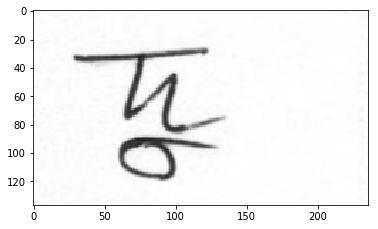

In [9]:
plt.imshow(ds[100000][0].permute(1, 2, 0).reshape(137, 236), cmap='gray', vmin=0, vmax=255)
ds[100000][1], ds[100000][2], ds[100000][3], ds[100000][0].max(), ds[100000][0].min()

In [10]:
# tmp = torch.nonzero(ds[100000][0] < 100)

In [11]:
# tmp[:, 1].max(), tmp[:, 1].min(), tmp[:, 2].max(), tmp[:, 2].min()

In [12]:
tr_indices, va_indices = train_test_split(list(range(len(ds))), test_size=.1, train_size=.9, random_state=42)#, stratify=ds.tensors[1])

In [13]:
tr_ds = Subset(ds, tr_indices)
va_ds = Subset(ds, va_indices)

In [14]:
len(ds), len(tr_ds), len(va_ds)

(200840, 180756, 20084)

In [15]:
n_graphemes, n_vowel_diacs, n_consonant_diacs = len(set(df_train['grapheme_root'])), len(set(df_train['vowel_diacritic'])), len(set(df_train['consonant_diacritic']))

In [16]:
def make_linear_block(in_size, out_size):
    block = nn.Sequential(
        nn.Linear(in_size, out_size), 
        nn.ReLU(), 
        nn.BatchNorm1d(num_features=out_size),
    )
    nn.init.xavier_normal_(block[0].weight.data)
    nn.init.zeros_(block[0].bias.data)
    return block

def make_ff_predictor(in_size, intermediate_size, out_size, layer_count):
    layers = [make_linear_block(in_size, intermediate_size)]
    for i in range(layer_count):
        layers.append(make_linear_block(intermediate_size, intermediate_size))
    layers.append(make_linear_block(intermediate_size, out_size))
    layers = nn.Sequential(*layers)
    return layers

def make_squeeze_predictor(in_size, out_size):
    return nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(in_size, out_size, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten()
        )

class BanglaHandwrittenGraphemeNN(nn.Module):
    def __init__(self):
        super(BanglaHandwrittenGraphemeNN, self).__init__()
#         base = models.squeezenet1_0(pretrained=True).features
        base = models.resnet50(pretrained=False)
        base.load_state_dict(torch.load('/kaggle/input/pretrained-pytorch-models/resnet50-19c8e357.pth'))
        base.fc = nn.Identity()
        self.base = base
        feature_size = 2048
        self.grapheme_predictor = make_ff_predictor(feature_size, 512, n_graphemes, 2)
        self.vowel_diac_predictor = make_ff_predictor(feature_size, 512, n_vowel_diacs, 1)
        self.consonant_diacs = make_ff_predictor(feature_size, 512, n_consonant_diacs, 1)

    def convert_to_grayscale(self):
        with torch.no_grad():
            conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            conv1.weight.data = torch.sum(model.base.conv1.weight.data, dim=1, keepdim=True)
            self.base.conv1 = conv1
            
    def freeze(self):
        for p in self.base.parameters():
            p.requires_grad = False
        
    def unfreeze(self):
        for p in self.base.parameters():
            p.requires_grad = True
        
    def forward(self, x):
#         with torch.no_grad():
        features = self.base(x)
        g_pred = self.grapheme_predictor(features)
        v_pred = self.vowel_diac_predictor(features)
        c_pred = self.consonant_diacs(features)
        return g_pred, v_pred, c_pred

In [17]:
class MultiTaskLoss(nn.Module):
    def __init__(self, num_tasks, init_weight=None):
        super(MultiTaskLoss, self).__init__()
        self.n = num_tasks
        if init_weight is None:
            self.w = nn.Parameter(torch.ones(self.n))
        else:
            self.w = nn.Parameter(torch.tensor(init_weight))

    def forward(self, losses):
        return torch.sum(self.w * losses) - torch.sum(torch.sum(torch.log(self.w)))

In [18]:
model = BanglaHandwrittenGraphemeNN().to(device)

In [19]:
model.convert_to_grayscale()

In [20]:
model.freeze()

In [21]:
tr_dl = DataLoader(tr_ds, batch_size=256, num_workers=0, pin_memory=True, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=256, num_workers=0, pin_memory=True)

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
# mtl_criterion = MultiTaskLoss(3)

In [24]:
# optimizer = optim.Adam([{'params': model.parameters()}, {'params': mtl_criterion.parameters(), 'lr': 1e-2}])
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [25]:
tr_losses = []
va_losses = []

In [26]:
mean = lambda l: sum(l) / len(l)


7.759745276800476 4.626282413069902 1.5427747936194822 1.5906880701110926



6.718747526784487 (4.055628767496423, 1.2985356774511216, 1.3645830818369418)
0.09753175789905172
0.5627110638962318
0.5277804420978063
[[2483  560   71  166  201  156  173  302   81   27   28]
 [ 387 2408   97  206   51   37   27  126   31  244   48]
 [  88  109 1825  292   18   10   17   50   45   43   80]
 [  61   88  148 1176   15    9    6   13    9   12   42]
 [ 225   60   17   44 1151  129   91   99   50    3   12]
 [  82   54    7   10   58  225   44   31    5    3    3]
 [  77   18    1    6   40   52  239    8    6    1    0]
 [ 196  148   51   64   49   28   37 1755  110  336   85]
 [  38   15   19   11    5    6    7   82  122   13   15]
 [  13  239   25   29    5    3    5  267   26  897  109]
 [   1   17   30   40    0    1    1   43   10   77  137]]
[[8091  486  886   76 1846 1071   99]
 [  88  488   48    7   24   33    5]
 [ 401  111 1578   32   69  104   13]
 [   3    8   11   22   14    3    1]
 [ 307   33   35   17 1629   88   38]
 [ 729  105  100   22  226  969   

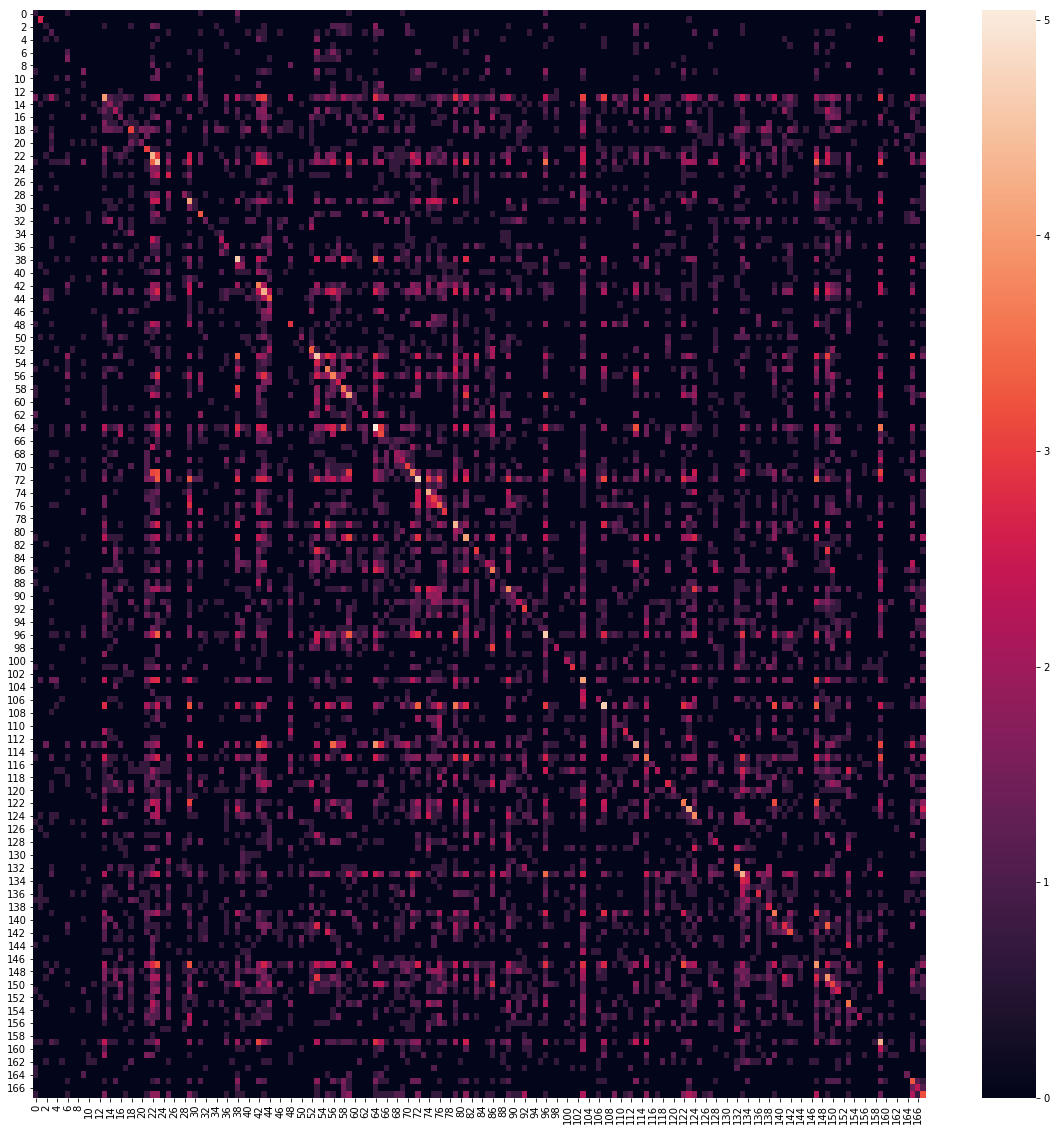


7.018614290037115 4.200111320871949 1.3718426993915014 1.4466602697736641



6.237171097646786 (3.699111123628254, 1.1688495648058155, 1.369210409212716)
0.14780605004443317
0.6205744886232638
0.541542662452781
[[2676  617   77   91  169  105  120  250   98   30   15]
 [ 326 2617   90  135   33   19   12  103   50  238   39]
 [  60   88 2009  178   10    4    6   44   64   43   71]
 [  51   90  126 1193   10    3    4    9   18   16   59]
 [ 268   67   20   18 1226   87   51   82   54    7    1]
 [ 105   48    6    3   61  223   35   23   12    5    1]
 [  83   24    3    0   47   39  235    8    9    0    0]
 [ 145  149   38   27   30   13   17 1759  165  427   89]
 [  17   16   17    2    2    3    1   55  195   13   12]
 [   7  201   13   10    1    2    3  172   43 1055  111]
 [   2   13   18   27    0    0    0   25   21   76  175]]
[[7466  512 2036   45 1305 1141   50]
 [  48  500   97    4   16   26    2]
 [ 176   67 1957    9   25   66    8]
 [   0    2   27   11   17    3    2]
 [ 272   22  103    9 1626   77   38]
 [ 545   86  253   15  136 1144   31

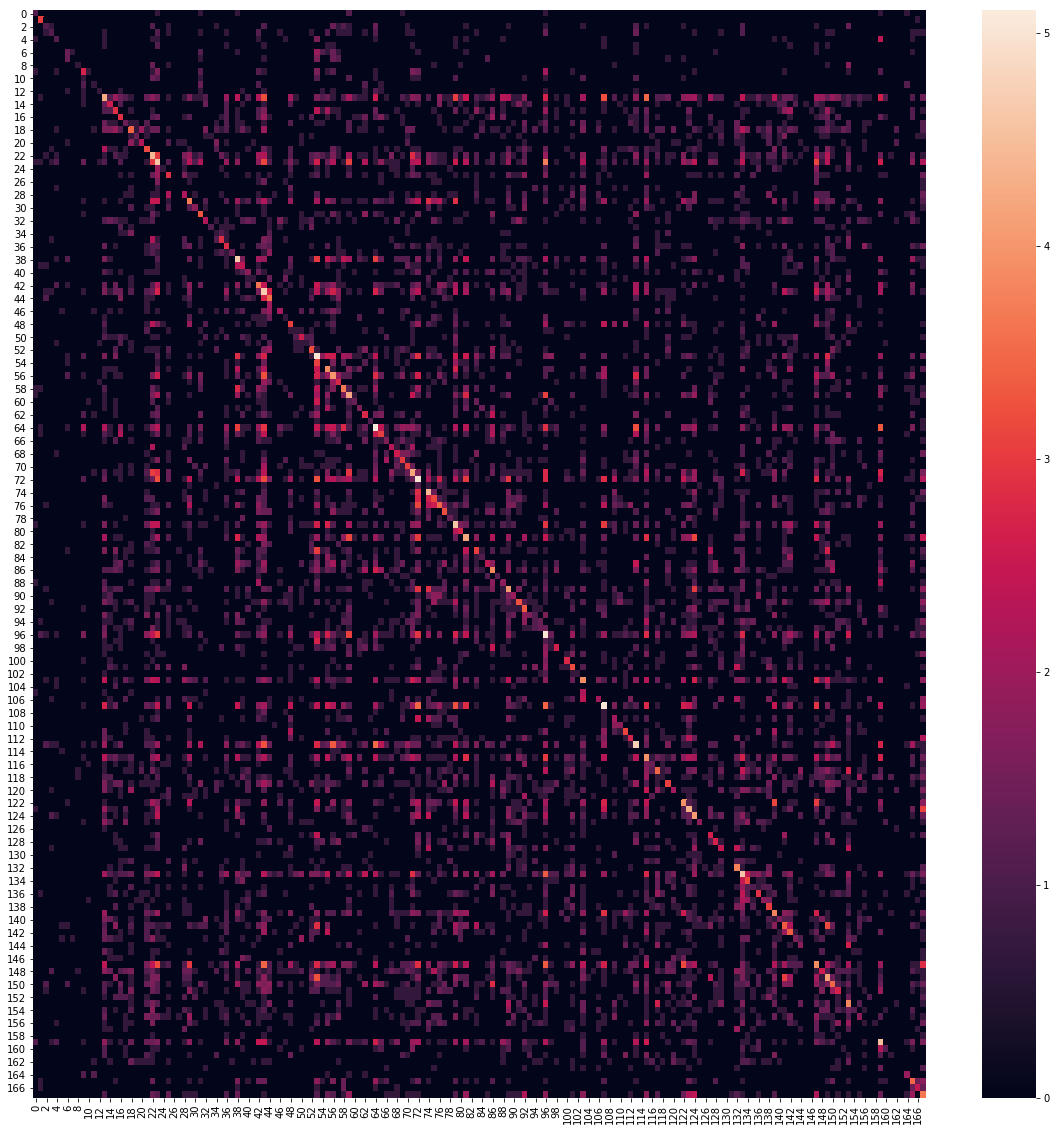


6.561125193716838 3.9467454506281916 1.2652117368299294 1.3491680062587168



5.696698572816728 (3.5080032318453247, 1.055264097225817, 1.1334312437455865)
0.1815316908672544
0.638946172296966
0.5409810881191882
[[2727  441  107   74  216  148  147  315   49   19    5]
 [ 368 2568  122  113   50   34   18  169   35  161   24]
 [  52   68 2221   91   11    5    7   43   38   12   29]
 [  40   93  190 1168   11    8    4   17    7    7   34]
 [ 221   38   24    9 1304  117   58   88   20    2    0]
 [  82   40   10    2   63  259   34   29    2    1    0]
 [  70   11    3    0   46   41  267    8    2    0    0]
 [ 132   88   38   18   40   16   13 2239   46  188   41]
 [  19   11   23    3    3    3    4   94  161    6    6]
 [   9  167   30    9    1    1    0  366   19  944   72]
 [   2   11   24   25    1    0    0   63    9   62  160]]
[[9206  238 1117   12  816 1123   43]
 [  66  496   76    1   16   37    1]
 [ 313   55 1807    4   25   99    5]
 [   1    2   29    9   18    3    0]
 [ 396   18   51    4 1570   77   31]
 [ 704   49  119    2   87 1236   13

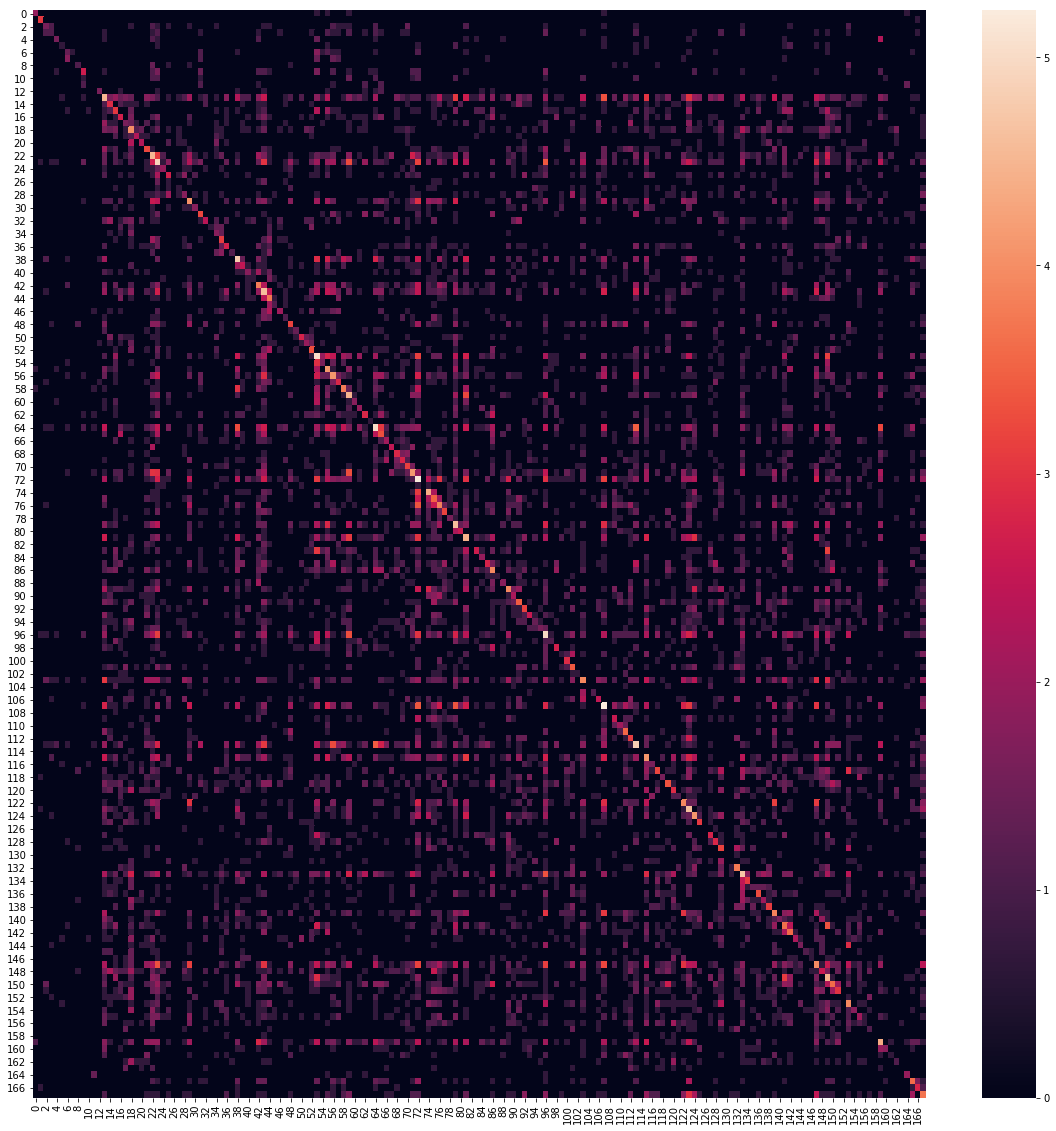


6.21828560316158 3.7578429881551814 1.1865230527043849 1.2739195623020134



5.490102906015855 (3.384243931951402, 0.9956572636773314, 1.1102017103871213)
0.21504652094822715
0.6410062267333984
0.5692667821659579
[[2978  519   83   73  207  122  118  107   26   13    2]
 [ 413 2837   99   97   47   19   13   43   17   66   11]
 [  83   88 2226  116    7    4    3   18    8   10   14]
 [  63  116  132 1220   12    5    0    4    3    6   18]
 [ 241   44   19   13 1357  102   61   35    8    1    0]
 [  91   48    7    2   68  257   35   11    2    1    0]
 [  83   15    3    0   45   39  256    4    2    0    1]
 [ 281  213   71   31   62   20   12 1819   62  231   57]
 [  37   23   31    2    4    1    3   52  167    5    8]
 [  18  357   34   13    4    2    1  192   24  896   77]
 [   3   29   30   40    1    0    0   24   12   53  165]]
[[9098  286  769   25 1597  747   33]
 [  77  526   47    1   18   23    1]
 [ 389   77 1719    8   47   64    4]
 [   0    2   16   16   26    2    0]
 [ 267   17   38    3 1775   26   21]
 [ 734   73   88    3  192 1099   

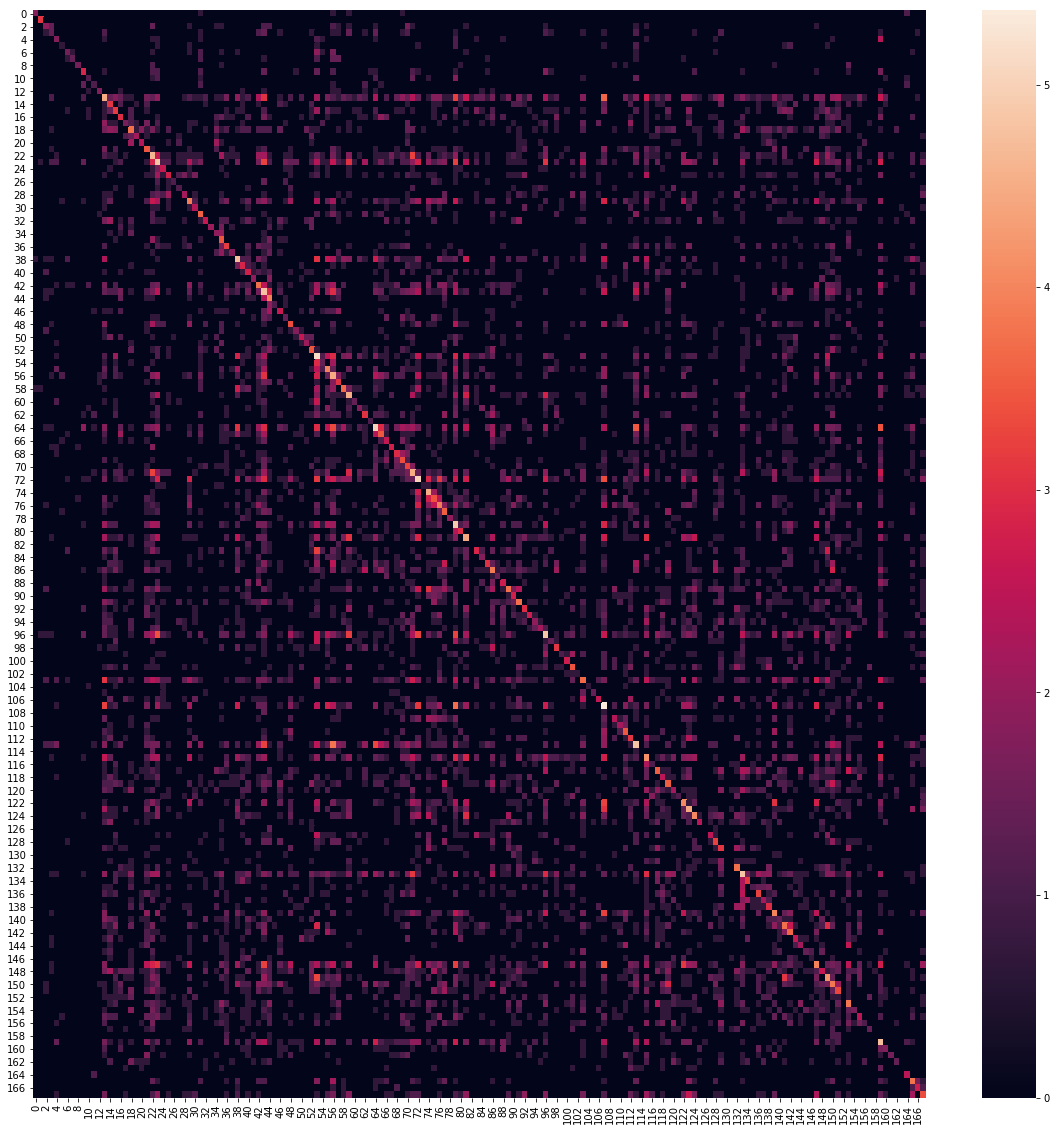


5.937377401170501 3.602916302269554 1.123065641594068 1.2113954573068795



5.22388827574404 (3.291787693772135, 0.9557446037666707, 0.9763559782052342)
0.22347435181783837
0.6601290552065652
0.5548956172413806
[[2924  380   89   49  198  193  148  208   41   14    4]
 [ 452 2644  116   82   51   48   22  107   30   96   14]
 [  60   63 2276   69   17    8    1   32   19   10   22]
 [  65  108  152 1165   17   11    1   14    7    6   33]
 [ 243   27   12    5 1369  116   43   51   14    0    1]
 [  78   31    4    1   67  289   36   13    1    2    0]
 [  68    8    2    0   48   53  259    8    2    0    0]
 [ 186  121   35   16   46   32   11 2153   57  166   36]
 [  24   14   21    2    3    6    0   68  183    6    6]
 [  14  233   35    7    3    1    2  314   28  903   78]
 [   3   18   20   25    1    0    1   42   12   53  182]]
[[10229   237   556    10   704   799    20]
 [   86   544    30     1     7    24     1]
 [  474   108  1605     5    22    89     5]
 [    3     4    15    15    22     3     0]
 [  426    21    25     2  1596    57    20]


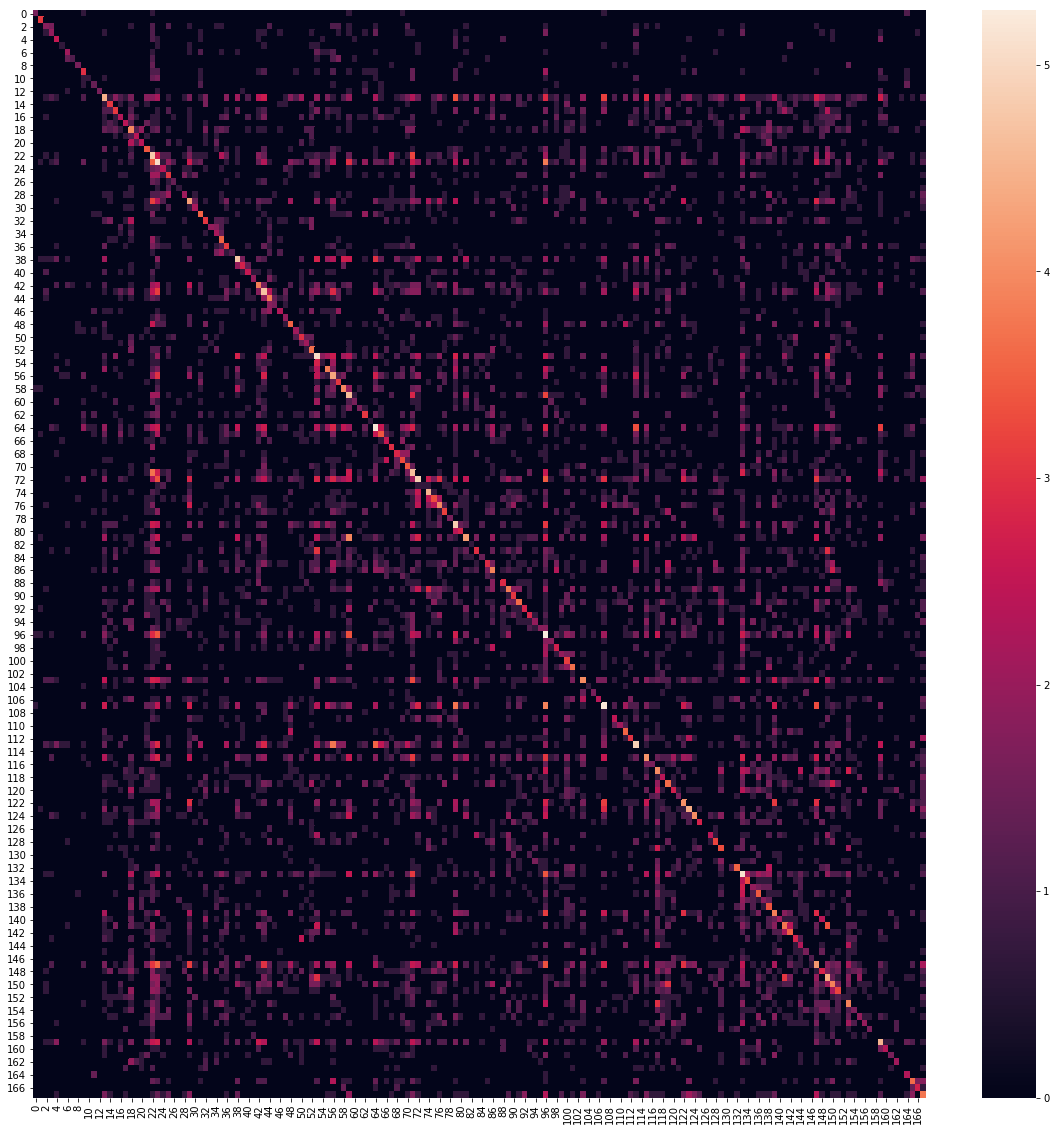


5.696280818848832 3.469642406980253 1.0698123995086484 1.1568260123599312



5.098090152951735 (3.226953313320498, 0.9165190171591843, 0.9546178224720533)
0.24191169986711025
0.6527253782792264
0.5776641566204092
[[3130  335   74   61  129   96  125  247   34   15    2]
 [ 537 2504   96  108   33   28   23  167   25  137    4]
 [  81   46 2250  108    8    3    4   44   15    9    9]
 [  76   79  130 1232    9    4    2   16    1   10   20]
 [ 314   29   14   12 1247   88   66   95   15    0    1]
 [ 108   34    3    2   50  248   48   26    3    0    0]
 [  78    3    1    0   31   35  287   12    1    0    0]
 [ 171   86   37   18   17   12   18 2318   42  127   13]
 [  24   15   22    1    1    3    2   81  177    5    2]
 [  12  149   31    8    2    0    1  429   26  914   46]
 [   2   15   20   28    1    0    0   70   13   58  150]]
[[9944  178  761    9  478 1157   28]
 [  85  525   41    1    7   34    0]
 [ 378   49 1753    3   15  106    4]
 [   3    3   20   19   15    2    0]
 [ 482   18   34    6 1467   98   42]
 [ 749   40   86    0   42 1281   

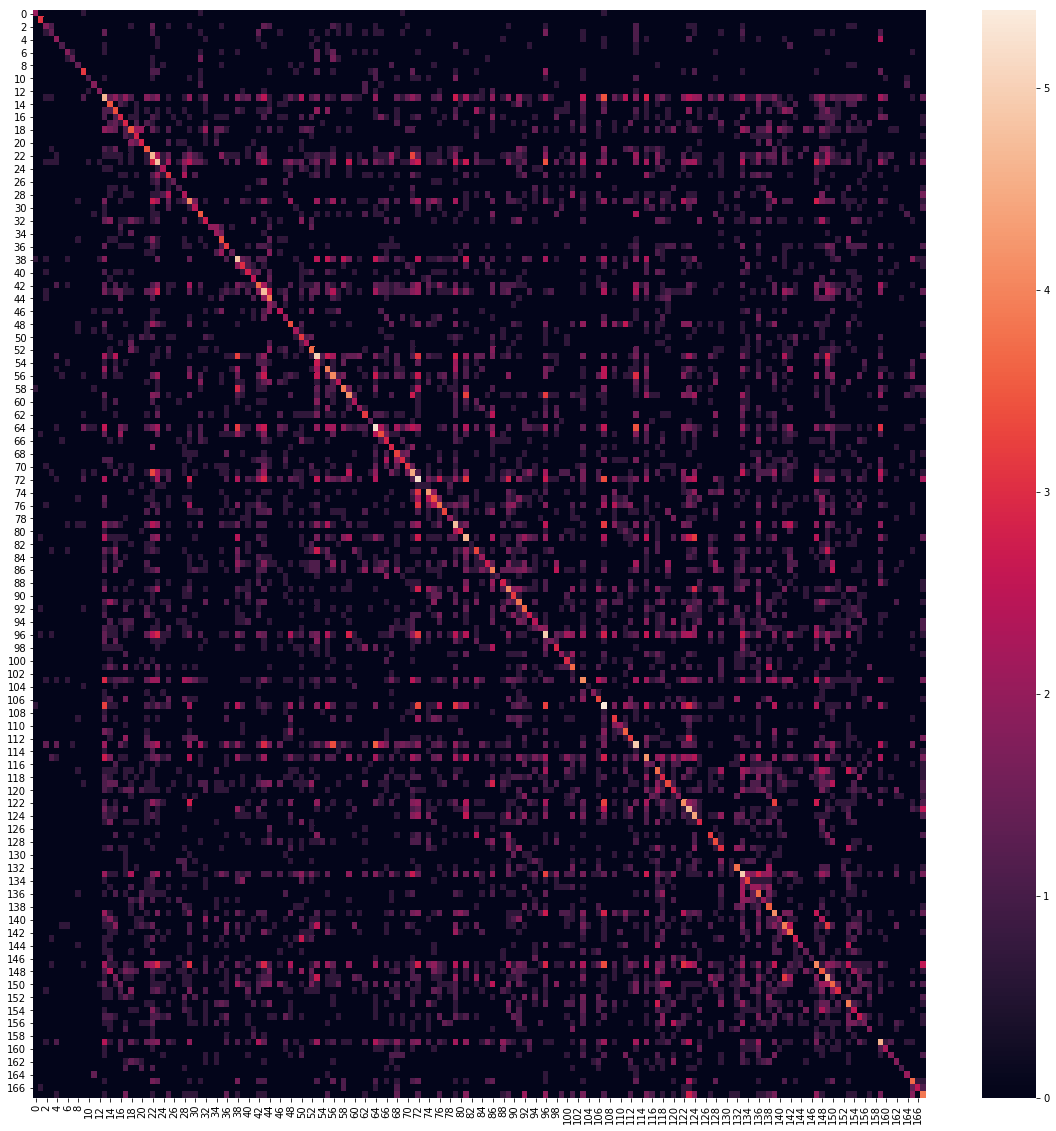


5.484395706056223 3.3523072417419737 1.023629683717426 1.1084587805968242



5.036302691773523 (3.1545395368262183, 0.9362582451180567, 0.9455049098292484)
0.24546991720622208
0.6434459047548274
0.5711164282835243
[[2585  593  106   31  233   76   81  443   58   38    4]
 [ 236 2655  101   48   42    9    9  182   24  339   17]
 [  37   62 2294   32   10    3    2   61   20   34   22]
 [  40  149  239 1010   15    4    0   31    7   32   52]
 [ 193   54   15    5 1395   56   22  123   14    2    2]
 [  86   48   10    1   81  228   21   37    7    3    0]
 [  70   16    5    0   50   41  245   17    4    0    0]
 [  76   77   37    2   35    6    4 2193   49  350   30]
 [  10   10   16    0    4    1    1   95  174   16    6]
 [   4   98   21    1    3    0    0  219   13 1225   34]
 [   0   11   21    9    1    0    0   44   12  101  158]]
[[10044   251   828     7   316  1079    30]
 [   72   545    41     2     6    26     1]
 [  360    69  1772     2     5    99     1]
 [    1     3    25    16    13     4     0]
 [  561    24    50     4  1367    98    43

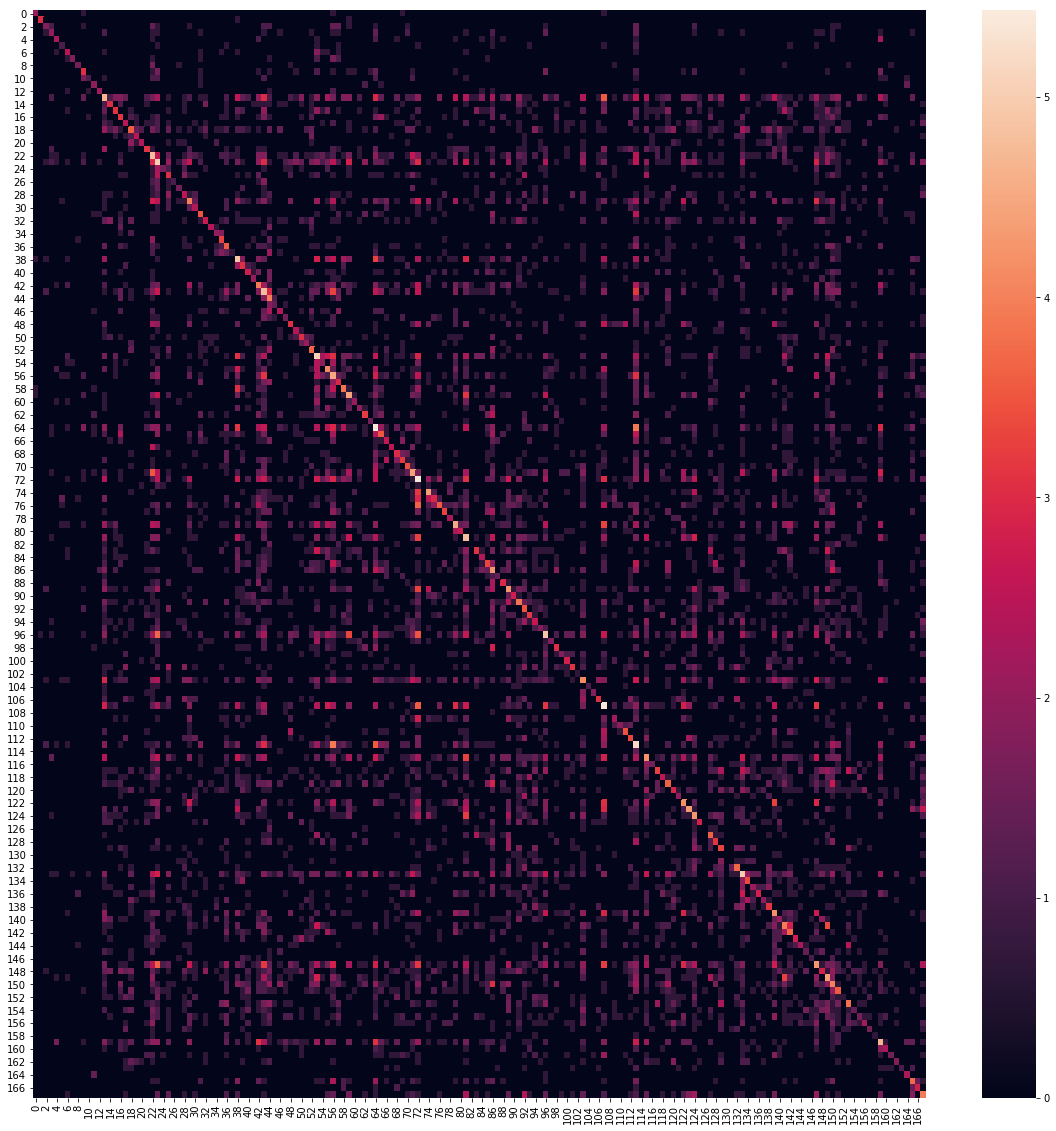


4.814357639317097 2.982357558024425 0.8806592927994421 0.9513407884932307



4.547755307438402 2.835615046640927 0.8247723097952182 0.8873679510022568



4.882664808744117 (3.141178414791445, 0.8756132344656353, 0.8658731594870362)
0.28066834643572963
0.6351024571825221
0.608436222809889
[[3222  340   39   45  202   64   91  218   11   13    3]
 [ 606 2555   57   89   46   20   12  162   12   95    8]
 [ 120   80 2121  134   12    5    4   63   11   12   15]
 [ 106  101   85 1225   14    2    2   18    2    6   18]
 [ 277   32    3   10 1376   50   49   80    3    0    1]
 [ 122   28    5    0   91  219   34   22    0    1    0]
 [  95    7    1    2   37   36  257   10    3    0    0]
 [ 223   77   20   10   22   12    6 2329   13  131   16]
 [  55   19   13    2    2    1    2   94  134    9    2]
 [  15  191   15   12    6    0    1  457    8  862   51]
 [   3   18   13   31    1    0    0   72    2   54  163]]
[[10086   156   301    17  1006   928    61]
 [   91   529    21     0    18    29     5]
 [  595    67  1450    21    37   130     8]
 [    0     1    12    29    17     3     0]
 [  326    14    21     7  1685    43    51]


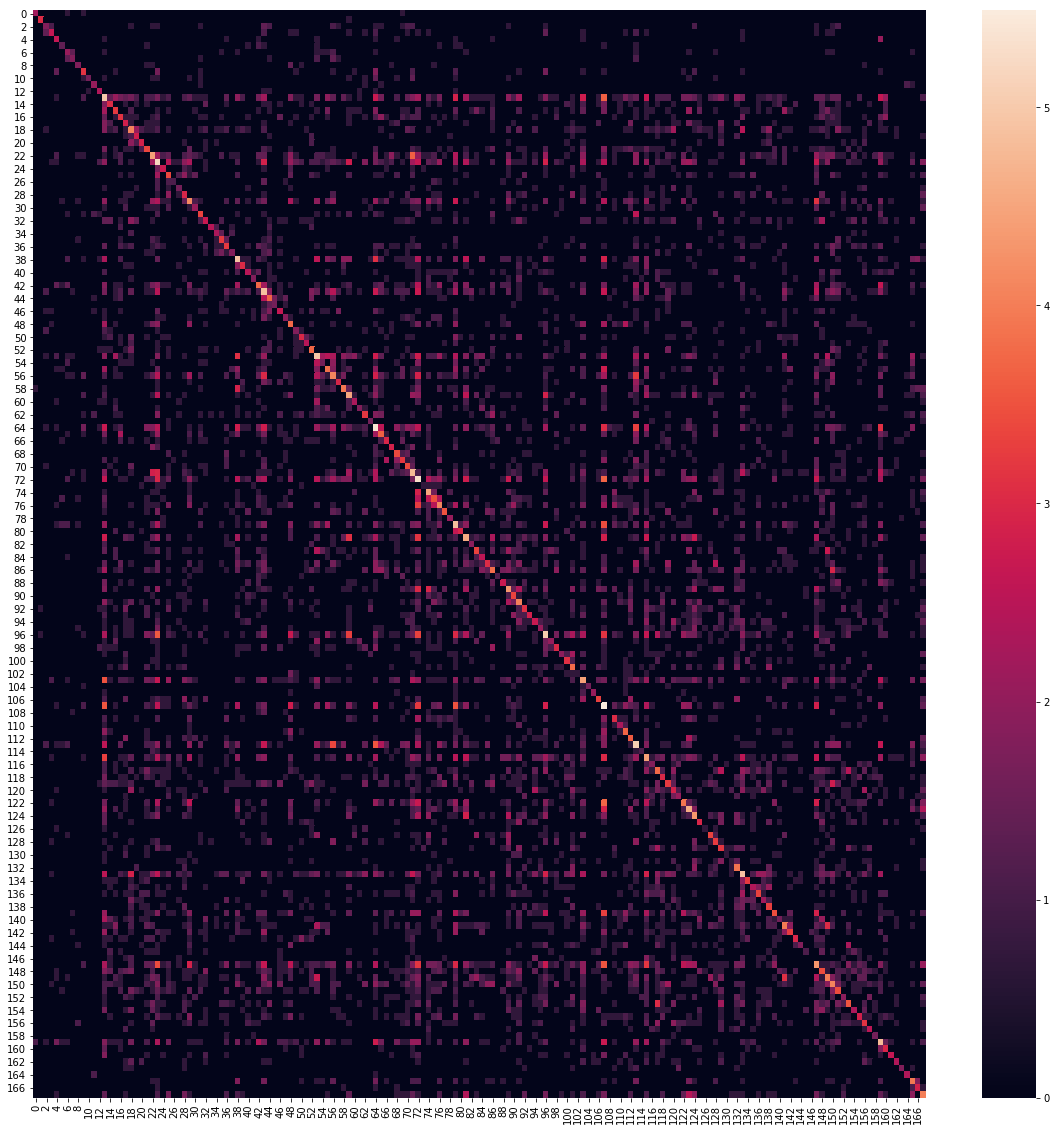


4.932330539709405 (3.255481062056143, 0.9007737297046033, 0.7760757479486586)
0.29525174660101017
0.6369512821275092
0.546806989862297
[[3162  462   54   42  197   44   64  179   30   13    1]
 [ 523 2723   70   61   37   12    5   98   31  100    2]
 [  95  106 2187   89   10    3    4   42   21   14    6]
 [  89  161  136 1141   12    1    0   12    4   11   12]
 [ 325   49    8   12 1336   51   34   54   10    1    1]
 [ 155   37    5    1   68  207   25   15    6    3    0]
 [ 113   13    2    1   49   24  238    6    1    0    1]
 [ 231  118   30   11   38    5    7 2125   85  194   15]
 [  34   17   14    2    2    1    1   50  202    8    2]
 [  11  234   22    9    4    0    1  321   26  963   27]
 [   3   25   19   31    1    0    1   58   12   77  130]]
[[11024   104   501     8   361   547    10]
 [  128   490    47     0     9    17     2]
 [  545    44  1640     7    11    57     4]
 [    9     2    17    21    11     2     0]
 [  603    16    38     8  1389    60    33]


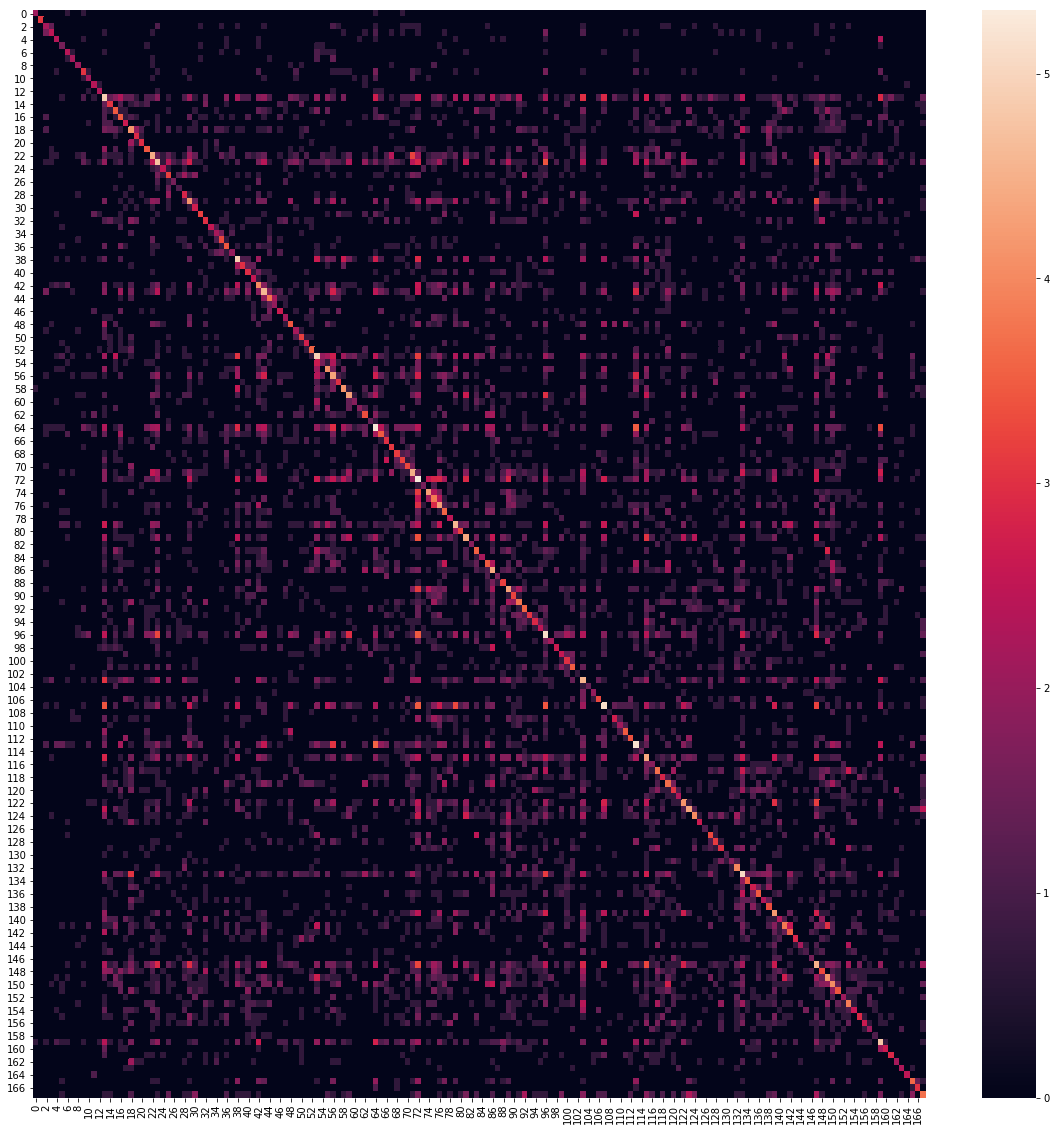

In [27]:
num_epochs = 20
epochs = range(num_epochs)
# epochs = notebook.tqdm(range(num_epochs))
for epoch in epochs:
    model.train()
    count = 0
    batches = tr_dl
    batches = notebook.tqdm(tr_dl)
    for batch in batches:
        count += 1
        optimizer.zero_grad()
        img, g, v, c = batch
        img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
        img = img / 255.0
        g_pred, v_pred, c_pred = model(img)
        g_loss = criterion(g_pred, g)
        v_loss = criterion(v_pred, v)
        c_loss = criterion(c_pred, c)
        loss = 2.0 * g_loss + v_loss + c_loss
#         loss = mtl_criterion(torch.stack((g_loss, v_loss, c_loss)))
#         batches.set_description("{:0.4f} {:0.4f} {:0.4f} {:0.4f}".format(loss.item(), g_loss.item(), v_loss.item(), c_loss.item()))
        loss.backward()
        optimizer.step()
        tr_losses.append((g_loss.item(), v_loss.item(), c_loss.item()))
#     print(mtl_criterion.w)
    print(mean([sum(t) for t in tr_losses]), mean([t[0] for t in tr_losses]), mean([t[1] for t in tr_losses]), mean([t[2] for t in tr_losses]))
    with torch.no_grad():
        model.eval()
        avg_g_loss = 0.0
        avg_v_loss = 0.0
        avg_c_loss = 0.0
        g_true = []
        v_true = []
        c_true = []
        g_preds = []
        v_preds = []
        c_preds = []
        count = 0
        batches = va_dl
        batches = notebook.tqdm(va_dl)
        for batch in batches:
            count += 1
            img, g, v, c = batch
            img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
            img = img / 255.0
            g_pred, v_pred, c_pred = model(img)
            g_loss = criterion(g_pred, g)
            v_loss = criterion(v_pred, v)
            c_loss = criterion(c_pred, c)
            avg_g_loss += g_loss.item()
            avg_v_loss += v_loss.item()
            avg_c_loss += c_loss.item()
            g_true.extend(g.tolist())
            v_true.extend(v.tolist())
            c_true.extend(c.tolist())
            g_preds.extend(g_pred.argmax(1).tolist())
            v_preds.extend(v_pred.argmax(1).tolist())
            c_preds.extend(c_pred.argmax(1).tolist())
        avg_g_loss /= count
        avg_v_loss /= count
        avg_c_loss /= count
        va_losses.append((avg_g_loss, avg_v_loss, avg_c_loss))
        print(sum(va_losses[-1]), va_losses[-1])
        print(recall_score(g_true, g_preds, average='macro'))
        print(recall_score(v_true, v_preds, average='macro'))
        print(recall_score(c_true, c_preds, average='macro'))
        print(confusion_matrix(v_true, v_preds))
        print(confusion_matrix(c_true, c_preds))
        plt.figure(figsize = (20, 20))
        sn.heatmap(np.log1p(confusion_matrix(g_true, g_preds)))
        plt.show()

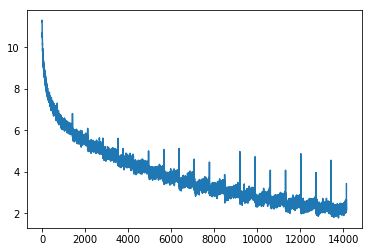

In [28]:
plt.plot([sum(t) for t in tr_losses])

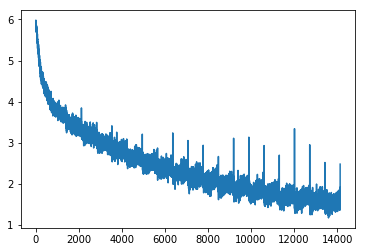

In [29]:
plt.plot([t[0] for t in tr_losses])

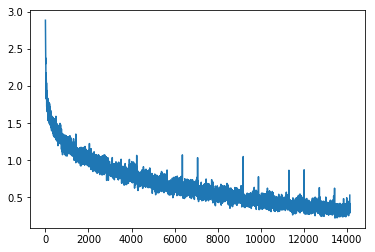

In [30]:
plt.plot([t[1] for t in tr_losses])

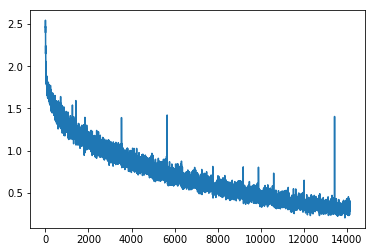

In [31]:
plt.plot([t[2] for t in tr_losses])

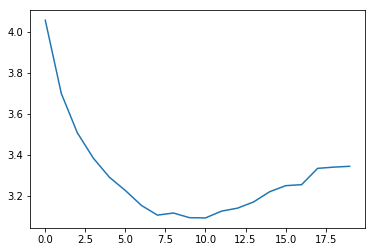

In [32]:
plt.plot([t[0] for t in va_losses])

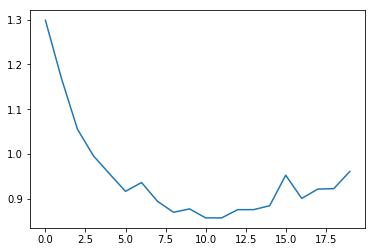

In [33]:
plt.plot([t[1] for t in va_losses])

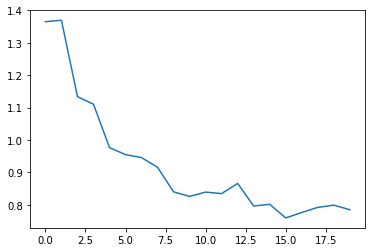

In [34]:
plt.plot([t[2] for t in va_losses])

In [35]:
torch.save(model.state_dict(), '/kaggle/working/model.pth')